In [1]:
import matplotlib.pyplot as plt

import json
import os
import torch
import numpy as np
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from collections import OrderedDict
from PIL import Image
from torch import Tensor

import helper
from importlib import reload
reload(helper)
#from helper import imshow_original, imshow

<module 'helper' from 'c:\\users\\pc\\anaconda3\\envs\\tensorflow\\lib\\site-packages\\helper\\__init__.py'>

In [2]:
torch.cuda.empty_cache() 

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
device

device(type='cuda', index=0)

In [5]:
data_dir = 'C:/Users/PC/Desktop/Dataset_FNS/NewDataset_19_11_2019'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
#test_dir = data_dir + '/test'
test_dir = 'C:/Users/PC/Desktop/FireNeutralSmoke_C++/mnist_c++/Dataset/test'

In [6]:
# Define transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(size=80),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

validation_transforms = transforms.Compose([
    transforms.Resize(100),
    transforms.CenterCrop(80),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load the datasets with ImageFolder
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
validation_dataset = datasets.ImageFolder(valid_dir, transform=validation_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=validation_transforms)

# Using the image datasets and the transforms, define the dataloaders
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=64, num_workers=4)
valid_dataloader = DataLoader(validation_dataset, shuffle=True, batch_size=64, num_workers=4)
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=64, num_workers=4)

In [7]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [8]:
category_map = sorted(cat_to_name.items(), key=lambda x: int(x[0]))

In [9]:
category_map

[('1', 'fire'), ('2', 'neutral'), ('3', 'smoke')]

In [10]:
category_names = [cat[1] for cat in category_map]

In [11]:
category_names

['fire', 'neutral', 'smoke']

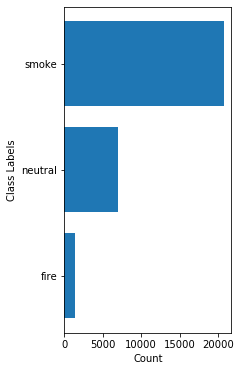

In [12]:
len(os.listdir(os.path.join("NewDataset_19_11_2019", "train")))

count = [len(os.listdir(os.path.join("NewDataset_19_11_2019", "train", dir))) for dir in os.listdir(os.path.join("NewDataset_19_11_2019", "train"))]
scalars = [*range(len(os.listdir(os.path.join("NewDataset_19_11_2019", "train"))))]
scalars = [x.__add__(1) for x in scalars]
plt.figure(figsize=(3,6))
plt.barh(scalars, count)
plt.yticks(scalars, category_names)
plt.xlabel("Count")
plt.ylabel("Class Labels")
plt.show()

In [13]:
count

[1440, 6995, 20696]

In [14]:
vgg16 = models.vgg16(pretrained = True)

In [15]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [16]:
# Freeze parameters so we don't backprop through them
for param in vgg16.parameters():
    param.requires_grad = False

classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(25088, 4096)),
                          ('relu1', nn.ReLU()),
                          ('dropout1', nn.Dropout(p=0.5)),
                          ('fc2', nn.Linear(4096, 1024)),
                          ('relu2', nn.ReLU()),
                          ('dropout2', nn.Dropout(p=0.5)),
                          ('fc3', nn.Linear(1024, 3)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
vgg16.classifier = classifier
vgg16.class_idx_mapping = train_dataset.class_to_idx

In [17]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.classifier.parameters(), lr=0.0001)

In [19]:
def validation(model, testloader, criterion, device):
    test_loss = 0
    accuracy = 0
    model.to(device)
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        # images.resize_(images.shape[0], 3, 224, 224)

        output = model.forward(images)
        test_loss += criterion(output, labels).item()

        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return test_loss, accuracy

In [20]:
def train(model, trainloader, validloader, epochs, print_every, criterion, optimizer, device='cuda'):
    steps = 0
    
    # Change to train mode if not already
    model.train()
    # change to cuda
    model.to(device)

    for e in range(epochs):
        running_loss = 0

        for (images, labels) in trainloader:
            steps += 1

            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward and backward passes
            outputs = model.forward(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if steps % print_every == 0:
                
                # Make sure network is in eval mode for inference
                model.eval()

                # Turn off gradients for validation, saves memory and computations
                with torch.no_grad():
                    validation_loss, accuracy = validation(model, validloader, criterion, device)
                    train_loss, train_accuracy = validation(model, trainloader, criterion, device)

                print("Epoch: {}/{}.. ".format(e+1, epochs),
                      "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                      #"Validation Loss: {:.3f}.. ".format(validation_loss/len(validloader)),
                      "Train Accuracy: {:.3f}".format((train_accuracy/len(trainloader))*100),
                      "Validation Accuracy: {:.3f}".format((accuracy/len(validloader))*100))

                model.train()
                
                running_loss = 0

In [21]:
train(model=vgg16, 
        trainloader=train_dataloader, 
        validloader=valid_dataloader,
        epochs=2, 
        print_every=60, 
        criterion=criterion,
        optimizer=optimizer,
        device="cuda")

Epoch: 1/2..  Training Loss: 0.474..  Train Accuracy: 85.562 Validation Accuracy: 91.895
Epoch: 1/2..  Training Loss: 0.360..  Train Accuracy: 86.943 Validation Accuracy: 91.136
Epoch: 1/2..  Training Loss: 0.304..  Train Accuracy: 87.823 Validation Accuracy: 91.131
Epoch: 1/2..  Training Loss: 0.302..  Train Accuracy: 87.344 Validation Accuracy: 90.594
Epoch: 1/2..  Training Loss: 0.278..  Train Accuracy: 88.962 Validation Accuracy: 91.191
Epoch: 1/2..  Training Loss: 0.276..  Train Accuracy: 88.481 Validation Accuracy: 91.094
Epoch: 1/2..  Training Loss: 0.280..  Train Accuracy: 89.539 Validation Accuracy: 91.577
Epoch: 2/2..  Training Loss: 0.111..  Train Accuracy: 89.453 Validation Accuracy: 91.082
Epoch: 2/2..  Training Loss: 0.260..  Train Accuracy: 89.258 Validation Accuracy: 91.759
Epoch: 2/2..  Training Loss: 0.260..  Train Accuracy: 90.307 Validation Accuracy: 91.320
Epoch: 2/2..  Training Loss: 0.258..  Train Accuracy: 88.538 Validation Accuracy: 91.211
Epoch: 2/2..  Trainin

In [22]:
def check_accuracy_on_test(testloader, model):    
    correct = 0
    total = 0
    model.to(device)
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total

In [23]:
test_accuracy = check_accuracy_on_test(test_dataloader, vgg16)
print('Accuracy of the network on the 10000 test images: %d %%' % test_accuracy)

Accuracy of the network on the 10000 test images: 95 %


In [24]:
test_dataset = datasets.ImageFolder('C:/Users/PC/Desktop/FireNeutralSmoke_C++/mnist_c++/Dataset/valid', transform=validation_transforms)
#test_dataset = datasets.ImageFolder('/home/a2-murat/Desktop/Dataset_FNS/Dataset/valid', transform=validation_transforms)
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=64, num_workers=4)

test_accuracy = check_accuracy_on_test(test_dataloader, vgg16)
print('Accuracy of the network on the 10000 test images: %d %%' % test_accuracy)

Accuracy of the network on the 10000 test images: 93 %


In [25]:
vgg16.class_idx_mapping = train_dataset.class_to_idx

In [26]:
torch.save(vgg16, "model_vgg16.pth")

In [18]:
import torch
from torchvision import datasets, models, transforms

def load_model(model_checkpoint):
    """
    Loads the model from a checkpoint file.

    Arguments: 
        model_checkpoint: Path to checkpoint file
    
    Returns: 
        model: Loaded model.
        idx_class_mapping: Index to class mapping for further evaluation.
    """

    checkpoint = torch.load(model_checkpoint)
    
    #model = models.vgg16(pretrained=True)
    
    #for param in model.parameters():
    #    param.requires_grad = False

    #model.classifier = checkpoint["classifier"]
    #model.load_state_dict(checkpoint["state_dict"])
    
    #return model
    return checkpoint

In [19]:
model = load_model(model_checkpoint="model.pth")

In [20]:
class_idx_mapping = train_dataset.class_to_idx
idx_class_mapping = {v: k for k, v in class_idx_mapping.items()}

In [27]:
def predict(image_path, model_checkpoint, topk=3, device="cpu", idx_class_mapping=idx_class_mapping):
    ''' 
    Predict the class (or classes) of an image using a trained deep learning model.
    
    Arguments:
        image_path: Path to the image
        model: Trained model
    Returns:
        classes: Top k class numbers.
        probs: Probabilities corresponding to those classes
    '''
    
    # Build the model from the checkpoint
    model = load_model(model_checkpoint)
    
    # No need for GPU
    model.to(device)
    
    model.eval()
     
    img = process_image(image_path)
    img = np.expand_dims(img, axis=0)
    img_tensor = torch.from_numpy(img).type(torch.FloatTensor).to(device)
    
    with torch.no_grad():
        log_probabilities = model.forward(img_tensor)
    
    probabilities = torch.exp(log_probabilities)
    probs, indices = probabilities.topk(topk)
    
    probs = probs.numpy().squeeze()
    indices = indices.numpy().squeeze()
    classes = [idx_class_mapping[index] for index in indices]
    
    return probs, classes

In [19]:


def process_image(img_path):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    img = Image.open(img_path)
    w, h = img.size
    if w<h:
        size = 256, 999999999
    else:
        size = 999999999, 256

    img.thumbnail(size=size)
    
    w, h = img.size
    left = (w - 224) / 2
    right = (w + 224) / 2
    top = (h - 224) / 2
    bottom = (h + 224) / 2
    
    img = img.crop((left, top, right, bottom))
    
    # Convert to numpy array
    np_img = np.array(img)/255
    
    # Normalize
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    np_img = (np_img - mean) / std
    
    np_img = np_img.transpose(2, 0, 1)
    
    return np_img



In [17]:
idx_class_mapping

{0: '1', 1: '2', 2: '3'}

In [32]:
probs, classes = predict("/home/a2-murat/Desktop/mnist_c++/Dataset/valid/3/Smoke_0_230.jpg", "model.pth", idx_class_mapping = idx_class_mapping)

In [33]:
print(probs)
print(classes)

[9.9898845e-01 9.3350216e-04 7.7986348e-05]
['3', '2', '1']


In [27]:
import PIL

mnist_testset = datasets.ImageFolder(test_dir, transform=None)
train_image, train_target= mnist_testset[20]



#device = torch.device("cuda" if use_cuda else "cpu")
device = torch.device("cpu")
model = torch.load("C:/Users/PC/Desktop/Dataset_FNS/model_vgg16.pth").to(device)

model.eval()

loader = transforms.Compose([
    transforms.Resize(100),
    transforms.CenterCrop(80),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

tensor_image = loader(train_image).unsqueeze(0).to(device)

traced_net = torch.jit.trace(model,tensor_image)
traced_net.save("model_trace_vgg16.pt")

print("Success - model_trace was saved!")


Success - model_trace was saved!
